In [5]:
import tensorflow as tf
import tensorflowjs as tfjs
from maml import MAML
from model import Model
from tasks import SinusoidRegressionTaskDistribution
from reptile import Reptile
import numpy as np
import matplotlib.pyplot as plt
from deployable import DeployableModel
from functools import partial
from pretrained import PretrainedModel
import time

#### inspiration have been taken from:
# https://github.com/luis-mueller/maml-tf2/blob/main/README.md
# https://github.com/greentfrapp/maml-reptile/blob/b45520c322d8ad1a4a7214e37cfc6f9b8b363658/README.md
# https://github.com/resibots/kaushik_2020_famle
# https://github.com/openai/supervised-reptile
# https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0
# https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb


#is gpu available?
print("GPU Available: ", tf.test.is_gpu_available())
#which cuda version?
print("CUDA Version:", tf.test.is_built_with_cuda())
#which tensorflow version?  
print("Tensorflow version:", tf.__version__)
#which tensorflowjs version?
print("Tensorflowjs version:", tfjs.__version__)
#which keras version?
print("Keras version:", tf.keras.__version__)



GPU Available:  True
CUDA Version: True
Tensorflow version: 2.18.0
Tensorflowjs version: 4.22.0
Keras version: 3.7.0


I0000 00:00:1734311714.514136  139735 gpu_device.cc:2022] Created device /device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


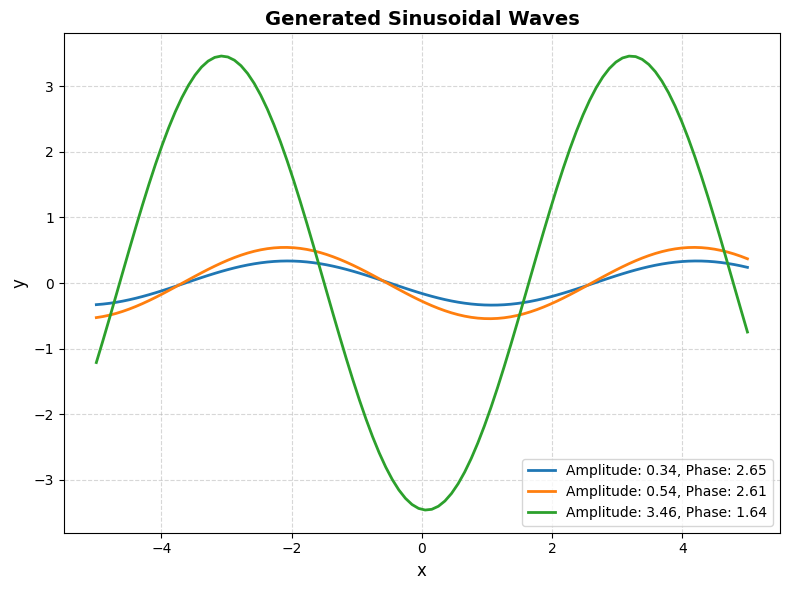

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sinusoidal_waves(task_distribution, num_waves=3, x_range=(-5, 5), num_points=100):
    """Generate and plot sinusoidal waves with random amplitudes and phases."""
    x = np.linspace(*x_range, num_points)  # Generate x values
    plt.figure(figsize=(8, 6))

    for _ in range(num_waves):
        task = task_distribution.sampleTask()
        y = task(x)  # Evaluate the sine wave
        plt.plot(x, y, label=f"Amplitude: {task.amplitude.numpy()[0]:.2f}, Phase: {task.phase.numpy()[0]:.2f}", linewidth=2)

    # Styling
    plt.title("Generated Sinusoidal Waves", fontsize=14, fontweight='bold')
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
task_distribution = SinusoidRegressionTaskDistribution()
plot_sinusoidal_waves(task_distribution)


In [47]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable


import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()  # Register the class for serialization
class PretrainModel(tf.keras.Model):
    def __init__(self, trainable=True, dtype="float32"):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(40, activation='relu', dtype=dtype, trainable=trainable)
        self.hidden2 = tf.keras.layers.Dense(40, activation='relu', dtype=dtype, trainable=trainable)
        self.out = tf.keras.layers.Dense(1, dtype=dtype, trainable=trainable)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

    def call(self, inputs, training=None):
        return self.forward(inputs)

    def get_config(self):
        # Include any arguments needed for reconstruction
        return {
            "trainable": self.trainable,
            "dtype": self.dtype_policy.name,
        }

    @classmethod
    def from_config(cls, config):
        # Create an instance of the class from its config
        return cls(**config)


@tf.function
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

def compute_loss(model, x, y, loss_fn):
    predictions = model.forward(x)
    loss = loss_fn(y, predictions)
    return loss, predictions

def compute_gradients(model, x, y, loss_fn):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients, loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

def train_batch(x, y, model, optimizer, loss_fn):
    gradients, loss = compute_gradients(model, x, y, loss_fn)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

def pretrain_model(task_distribution, epochs=5, nSamples=10, nTasks=25, nBatch=1000, lr=0.001, log_steps=100):
    model = PretrainModel()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Build the model by calling it once with dummy data
    dummy_input = tf.zeros((1, 1))
    model.forward(dummy_input)  # Ensure the model is initialized

    print("Pre-training the model...")
    start_time = time.time()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx in range(nBatch):
            x_train, y_train = [], []
            for _ in range(nTasks):
                task = task_distribution.sampleTask()
                x, y = task.sampleFromTask(nSamples)
                x_train.append(x)
                y_train.append(y)

            # Combine task data into a single batch
            x_train = tf.concat(x_train, axis=0)
            y_train = tf.concat(y_train, axis=0)

            # Train on the batch
            batch_loss = train_batch(x_train, y_train, model, optimizer, loss_function)
            total_loss += batch_loss
            curr_loss = total_loss / (batch_idx + 1.0)
            losses.append(curr_loss.numpy())  # Convert to NumPy for logging

            # Log progress at intervals
            if batch_idx % log_steps == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{nBatch}, Loss: {curr_loss.numpy():.4f}")

        # Log epoch results
        avg_loss = total_loss / nBatch
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss.numpy():.4f}")

    # Plot loss over time
    plt.plot(losses)
    plt.title('Loss vs. Training Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.show()

    end_time = time.time()
    print(f"Pre-training completed in {end_time - start_time:.2f} seconds")
    return model


Pre-training the model...
Epoch 1, Batch 1/1000, Loss: 8.3326
Epoch 1, Batch 101/1000, Loss: 8.2756
Epoch 1, Batch 201/1000, Loss: 8.3108
Epoch 1, Batch 301/1000, Loss: 8.3024
Epoch 1, Batch 401/1000, Loss: 8.3299
Epoch 1, Batch 501/1000, Loss: 8.3390
Epoch 1, Batch 601/1000, Loss: 8.3283
Epoch 1, Batch 701/1000, Loss: 8.3236
Epoch 1, Batch 801/1000, Loss: 8.3211
Epoch 1, Batch 901/1000, Loss: 8.3195
Epoch 1/5, Average Loss: 8.3259
Epoch 2, Batch 1/1000, Loss: 8.2793
Epoch 2, Batch 101/1000, Loss: 8.3556
Epoch 2, Batch 201/1000, Loss: 8.3758
Epoch 2, Batch 301/1000, Loss: 8.3693
Epoch 2, Batch 401/1000, Loss: 8.3793
Epoch 2, Batch 501/1000, Loss: 8.3821
Epoch 2, Batch 601/1000, Loss: 8.3801
Epoch 2, Batch 701/1000, Loss: 8.3791
Epoch 2, Batch 801/1000, Loss: 8.3608
Epoch 2, Batch 901/1000, Loss: 8.3533
Epoch 2/5, Average Loss: 8.3515
Epoch 3, Batch 1/1000, Loss: 9.0109
Epoch 3, Batch 101/1000, Loss: 8.2262
Epoch 3, Batch 201/1000, Loss: 8.2758
Epoch 3, Batch 301/1000, Loss: 8.2763
Epoc

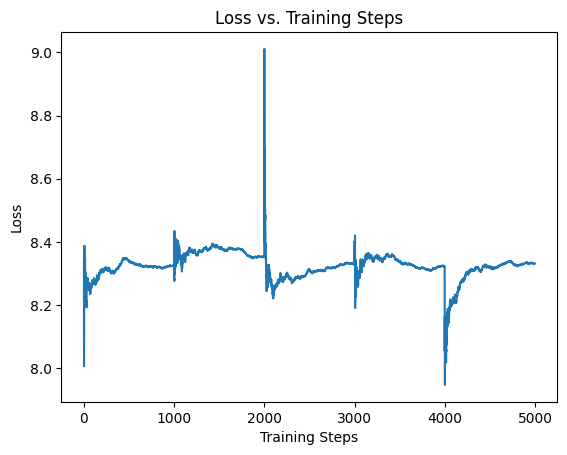

Pre-training completed in 417.74 seconds


In [48]:
# Task distribution
task_distribution = SinusoidRegressionTaskDistribution()

# Pre-train the model
pretrained_model = pretrain_model(task_distribution)



<img src="attachment:image.png" width="100"/>

In [49]:
pretrained_model.save('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/model.keras')

/home/kristmro/workspace/MetaLearningCodes/TestingSin/venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Evaluate the loss
def evaluate_loss(model, x, y):
    predictions = model(x)
    loss = tf.keras.losses.MeanSquaredError()(y, predictions)
    return loss, predictions

# Evaluate the model on a sine wave task
def eval_sine_test(model, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    fit_res = []
    tensor_x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
    tensor_y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Evaluate loss before any training
    if 0 in num_steps:
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits.numpy(), loss.numpy()))

    # Train for specified steps
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    for step in range(1, max(num_steps) + 1):
        with tf.GradientTape() as tape:
            predictions = model(tf.convert_to_tensor(x, dtype=tf.float32))
            loss = tf.keras.losses.MeanSquaredError()(tf.convert_to_tensor(y, dtype=tf.float32), predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append((step, logits.numpy(), loss.numpy()))

    return fit_res

def eval_sinewave_for_test(model_path, task, num_steps=(0, 1, 10), plot=True):
    """Evaluate the model's performance on a sine wave task.
    
    Args:
        model_path: Path to the pre-trained model in .keras format.
        task: An instance of SinusoidRegressionTask.
        num_steps: List of training steps to evaluate.
        plot: Whether to plot the results.
        
    Returns:
        Fit results: A list of step, predictions, and loss for each evaluation step.
    """
    # Generate training and test data from the task
    x_train = tf.random.uniform((10, 1), -5.0, 5.0)  # Random x-values for training
    y_train = task(x_train)  # Generate corresponding y-values on the curve
    x_test = tf.linspace(-5.0, 5.0, 100)[:, None]  # Smooth range of x-values for testing
    y_test = task(x_test)  # Generate corresponding y-values on the curve

    # Load the model from .keras file
    model = tf.keras.models.load_model(model_path)

    # Clone the model for evaluation
    copied_model = tf.keras.models.clone_model(model)
    copied_model.set_weights(model.get_weights())

    # Evaluate and train
    fit_res = eval_sine_test(copied_model, x_train, y_train, x_test, y_test, num_steps)

    # Plot results
    if plot:
        plt.scatter(x_train, y_train, color='red', label='Training Points')
        plt.plot(x_test, y_test, label='True Function', color='blue')
        for step, logits, _ in fit_res:
            plt.plot(x_test, logits[:, 0], '--', label=f'After {step} Steps')
        plt.legend()
        plt.ylim(-5, 5)
        plt.xlim(-6, 6)
        plt.title("Model Fine-tuning on New Sine Wave")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    return fit_res



In [51]:
#Making the different models
#!python3 ground/test.py maml-reproduce maml --epochs=70 --batch-size=1000 --training-tasks=25 --task-sample=10 --save-preliminary True
#!python3 ground/test.py fomaml-reproduce fomaml --epochs=70 --batch-size=1000 --training-tasks=25 --task-sample=10 --save-preliminary True
#!python3 ground/test.py reptile-reproduce reptile --epochs=70 --batch-size=1000 --training-tasks=25 --task-sample=10 --save-preliminary True



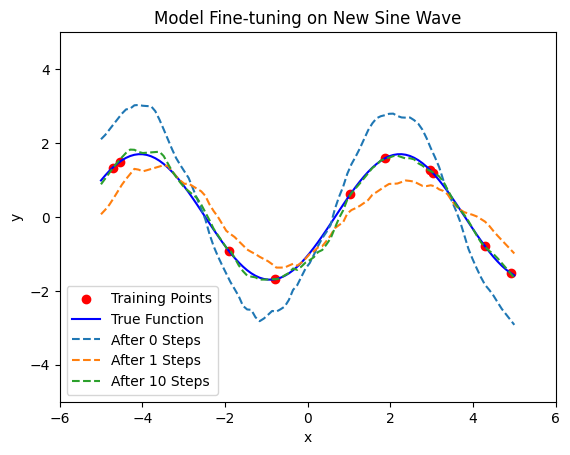

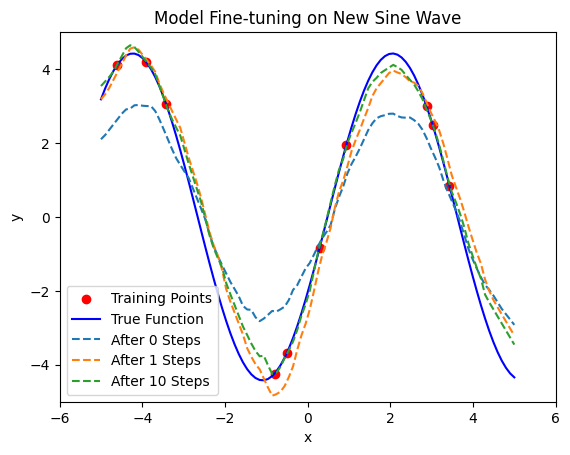

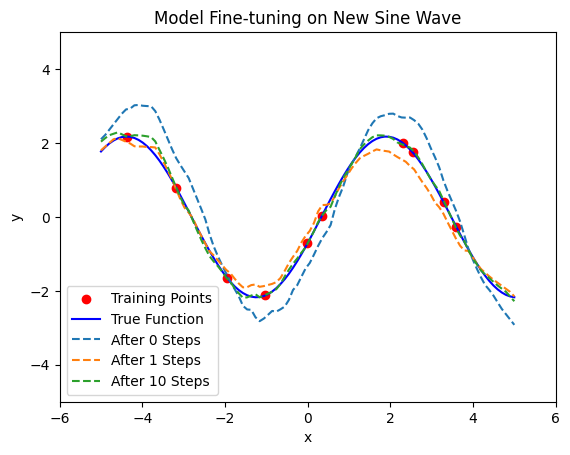

In [52]:
# Example usage:
task_distribution = SinusoidRegressionTaskDistribution()
model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras'

# Evaluate and plot for 3 random tasks
for _ in range(3):
    task = task_distribution.sampleTask()
    eval_sinewave_for_test(model_path, task)


In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_stepwise_loss(models, task, max_steps=10):
    """Compute the loss at each gradient step for multiple models.
    
    Args:
        models: List of tuples (model_name, model_path) to evaluate.
        task: An instance of SinusoidRegressionTask.
        max_steps: The maximum number of gradient steps to evaluate.
    
    Returns:
        A dictionary mapping model names to their stepwise losses.
    """
    # Generate training and test data
    x_train = tf.random.uniform((10, 1), -5.0, 5.0)  # Random x-values for training
    y_train = task(x_train)  # Corresponding y-values
    x_test = tf.linspace(-5.0, 5.0, 100)[:, None]
    y_test = task(x_test)  # Ground truth for the sine wave

    # Loss function
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Results container
    all_losses = {}

    # Loop through each model
    
    for model_name, model_path in models:
        print(f"Evaluating {model_name}...")
        model = tf.keras.models.load_model(model_path)

        # Clone model to avoid overwriting weights
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())

        # Optimizer
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

        # Store losses at each step
        step_losses = []

        for step in range(max_steps + 1):
            # Compute loss on test data
            test_loss = loss_fn(y_test, copied_model(x_test)).numpy()
            step_losses.append(test_loss)

            # Perform a gradient step on training data
            if step < max_steps:
                with tf.GradientTape() as tape:
                    predictions = copied_model(x_train)
                    loss = loss_fn(y_train, predictions)
                gradients = tape.gradient(loss, copied_model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, copied_model.trainable_weights))

        all_losses[model_name] = step_losses

    return all_losses

def plot_model_comparisons(losses_dict, max_steps=10):
    """Plot the stepwise losses for multiple models.
    
    Args:
        losses_dict: A dictionary mapping model names to their losses.
        max_steps: The number of gradient steps.
    """
    plt.figure(figsize=(8, 6))
    for model_name, losses in losses_dict.items():
        plt.plot(range(max_steps + 1), losses, label=model_name, marker='o')
    
    plt.title("Loss Comparison Across Gradient Steps")
    plt.xlabel("Gradient Steps")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()



Evaluating MAML...
Evaluating FOMAML...
Evaluating Basline...


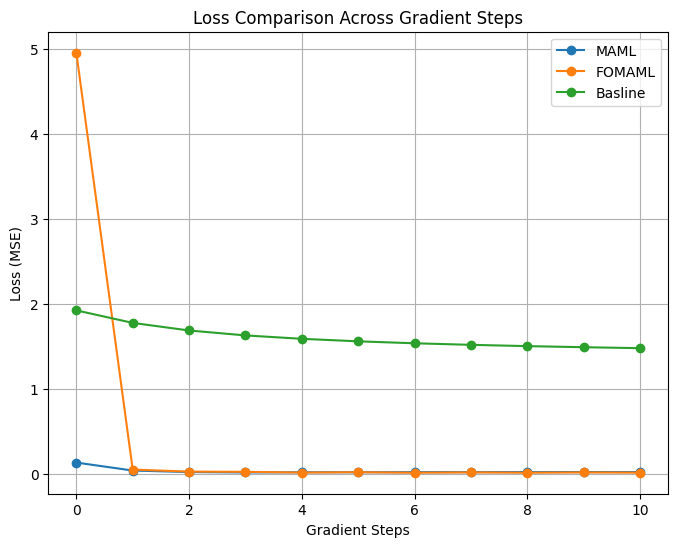

In [82]:
# Example usage
task_distribution = SinusoidRegressionTaskDistribution()
task = task_distribution.sampleTask()

# List of models: (model_name, model_path)
models = [
    ("MAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras"),
    ("FOMAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras"),
    ("Basline", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/model.keras"),
]

# Compute losses
stepwise_losses = compute_stepwise_loss(models, task, max_steps=10)

# Plot the losses
plot_model_comparisons(stepwise_losses, max_steps=10)


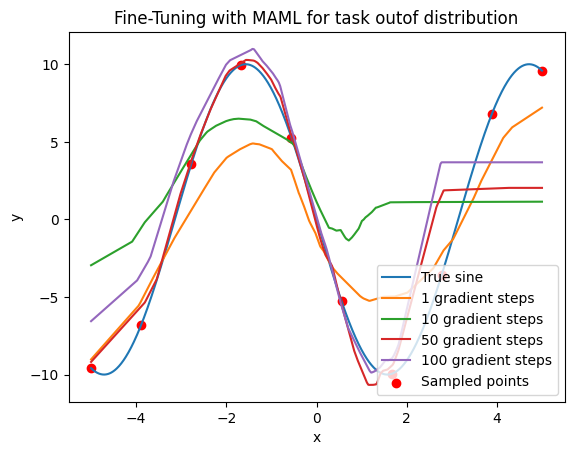

In [85]:

# Define the out of distribution task
def task(x):
    return 10 * tf.sin(x+np.pi)

# Generate training data points (xs, ys)
xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
ys = task(xs)

# Generate points for the true sine function
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting
plt.plot(x, task(x), label="True sine")

# Assume the model is loaded
maml_model = tf.keras.models.load_model('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras')

# Define a custom loss function (Mean Squared Error)
loss_fn = tf.keras.losses.MeanSquaredError()

# Fine-tuning loop
for n_steps in [1, 10, 50, 100]:
    # Initialize the model's trainable weights for fine-tuning
    updated_weights = maml_model.trainable_weights
    
    # Perform fine-tuning steps
    for step in range(n_steps):
        with tf.GradientTape() as tape:
            # Compute the loss on the current task
            predictions = maml_model(xs)
            loss = loss_fn(ys, predictions)
        
        # Compute gradients
        grads = tape.gradient(loss, maml_model.trainable_weights)
        
        # Apply gradients to update the weights
        for w, g in zip(updated_weights, grads):
            w.assign_sub(0.01 * g)  # Learning rate = 0.01

    # Make predictions with updated weights
    maml_model.set_weights(updated_weights)  # Apply updated weights
    predictions = maml_model(x)
    
    # Plot the predictions
    plt.plot(x, predictions, label=f"{n_steps} gradient steps")

# Plot the training points
plt.scatter(xs, ys, color='red', label='Sampled points')

# Finalize the plot
plt.title('Fine-Tuning with MAML for task outof distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

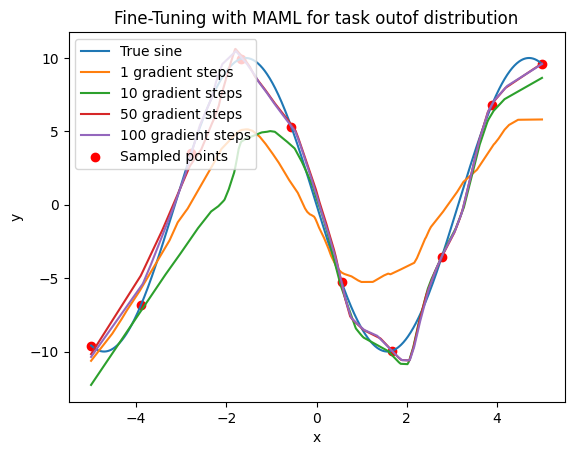

In [86]:

# Define the out of distribution task
def task(x):
    return 10 * tf.sin(x+np.pi)

# Generate training data points (xs, ys)
xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
ys = task(xs)

# Generate points for the true sine function
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting
plt.plot(x, task(x), label="True sine")

# Assume the model is loaded
maml_model = tf.keras.models.load_model('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras')

# Define a custom loss function (Mean Squared Error)
loss_fn = tf.keras.losses.MeanSquaredError()

# Fine-tuning loop
for n_steps in [1, 10, 50, 100]:
    # Initialize the model's trainable weights for fine-tuning
    updated_weights = maml_model.trainable_weights
    
    # Perform fine-tuning steps
    for step in range(n_steps):
        with tf.GradientTape() as tape:
            # Compute the loss on the current task
            predictions = maml_model(xs)
            loss = loss_fn(ys, predictions)
        
        # Compute gradients
        grads = tape.gradient(loss, maml_model.trainable_weights)
        
        # Apply gradients to update the weights
        for w, g in zip(updated_weights, grads):
            w.assign_sub(0.01 * g)  # Learning rate = 0.01

    # Make predictions with updated weights
    maml_model.set_weights(updated_weights)  # Apply updated weights
    predictions = maml_model(x)
    
    # Plot the predictions
    plt.plot(x, predictions, label=f"{n_steps} gradient steps")

# Plot the training points
plt.scatter(xs, ys, color='red', label='Sampled points')

# Finalize the plot
plt.title('Fine-Tuning with MAML for task outof distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()